# Analysis of Reactome pathway activities in PBMCs with VEGA

In this tutorial, we will demonstrate a use case for VEGA on single-cell PBMCs from Kang et al. The dataset is composed of 2 conditions (cells stimulated with interferon-beta and control cells). We will analyze the GMVs (Gene Module Variables) activities of the two populations.



In [1]:
# Load VEGA and packages
import sys
sys.path.append('../')
import vega
import pandas as pd
import scanpy as sc
# Ignore warnings in this tutorial
import warnings
warnings.filterwarnings('ignore')

## Loading and preparing data
We will load the PBMC data. The data were already preprocessed. As shown, the data is comprised of 16893 cells with 6998 highly variable genes.

In [2]:
adata = vega.data.pbmc()
print(adata)

AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'


VEGA is built around the ```scvi-tools``` ecosystem. As such, we need to run our own version of ```setup_anndata```, which in addition to locating covariates and important additional information also initializes attributes in the Anndata object that will be used by VEGA.

In [3]:
vega.utils.setup_anndata(adata)

Running VEGA and SCVI setup...
INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 16893 cells, 6998 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


## Creating and training the VEGA model

Similarly to ```scvi-tools```, it is very straightforward to create and train VEGA models. In addition to specifying the input Anndata object, we also specify the path to ```.gmt``` files that will be used to initialize VEGA's latent space, as well as the number of unnannotated variables to model with the ```add_nodes``` argument. Additionally, we force the weights of VEGA's linear decoder to be positive to aid interpretability when running differential activity tests later.


*Note: The model is initialized with a masked decoder as described in the original VEGA paper, but other regularization strategies are available (l1, ElasticNet, GelNet...)*

In [4]:
model = vega.VEGA(adata,
                  gmt_paths='../vega/data/reactomes.gmt',
                  add_nodes=1,
                  positive_decoder=True)
print(model)

Using masked decoder
Constraining decoder to positive weights
VEGA model with the following parameters: 
n_GMVs: 675, dropout_rate:0.1, z_dropout:0.3, beta:5e-05, positive_decoder:True
Model is trained: False


In [5]:
model.train_vega(n_epochs=50)

[Epoch 1] | loss: 331.439 |
[Epoch 2] | loss: 236.868 |
[Epoch 3] | loss: 210.888 |
[Epoch 4] | loss: 203.683 |
[Epoch 5] | loss: 200.081 |
[Epoch 6] | loss: 197.597 |
[Epoch 7] | loss: 195.700 |
[Epoch 8] | loss: 194.076 |
[Epoch 9] | loss: 192.903 |
[Epoch 10] | loss: 191.478 |
[Epoch 11] | loss: 190.245 |
[Epoch 12] | loss: 189.227 |
[Epoch 13] | loss: 188.143 |
[Epoch 14] | loss: 187.366 |
[Epoch 15] | loss: 186.178 |
[Epoch 16] | loss: 185.538 |
[Epoch 17] | loss: 184.696 |
[Epoch 18] | loss: 183.901 |
[Epoch 19] | loss: 183.318 |
[Epoch 20] | loss: 182.713 |
[Epoch 21] | loss: 182.158 |
[Epoch 22] | loss: 181.271 |
[Epoch 23] | loss: 180.924 |
[Epoch 24] | loss: 180.391 |
[Epoch 25] | loss: 179.938 |
[Epoch 26] | loss: 179.593 |
[Epoch 27] | loss: 179.010 |
[Epoch 28] | loss: 178.464 |
[Epoch 29] | loss: 178.168 |
[Epoch 30] | loss: 177.891 |
[Epoch 31] | loss: 177.364 |
[Epoch 32] | loss: 177.091 |
[Epoch 33] | loss: 176.875 |
[Epoch 34] | loss: 176.007 |
[Epoch 35] | loss: 175.

## Saving and reloading

To save and reload a trained VEGA model, simply use the following syntax. To verify that a model is trained, print the model variable.

In [6]:
#model.save('./vega_pbmc/', save_adata=True, save_history=True)

In [6]:
#model = vega.VEGA.load('.vega_pbmc/')
print(model)

VEGA model with the following parameters: 
n_GMVs: 675, dropout_rate:0.1, z_dropout:0.3, beta:5e-05, positive_decoder:True
Model is trained: True


## Analyzing model output
One primary feature of VEGA is to project the transcriptomes into an interpretable latent space representing the gene sets used to initalize the model.

In [7]:
model.adata.obsm['X_vega'] = model.to_latent()

#### UMAP with VEGA latent space

We can now use the interoperability with Scanpy to get a UMAP representation of the data based on VEGA's latent space.

In [8]:
sc.pp.neighbors(model.adata, use_rep='X_vega', n_neighbors=15)
sc.tl.umap(model.adata, min_dist=0.5, random_state=42)

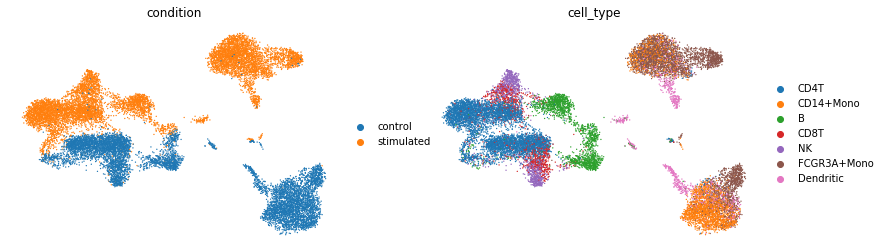

In [9]:
sc.pl.umap(model.adata, color=["condition", "cell_type"], frameon=False)

#### Analyzing GMV activities

We can now project cells into individual pathway components for biological processes of interest. Here, we are interested to see if we can use the interferon pathway activity to separate the 2 conditions. We expect interferon pathways to be activated in the *'stimulated'* condition. Also, we use the BCR signaling pathway to segregate B-cells from the rest of the dataset. 

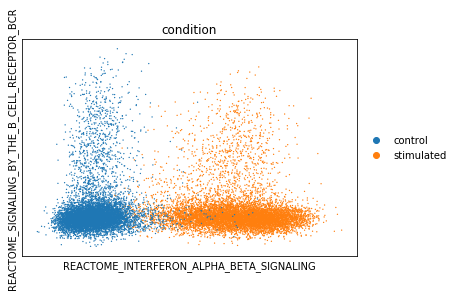

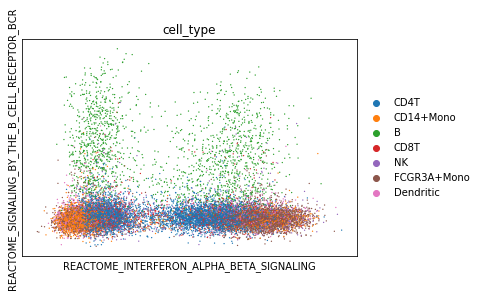

In [11]:
vega.plotting.gmv_plot(model.adata,
                       x='REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
                       y='REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR',
                       color='condition')
vega.plotting.gmv_plot(model.adata,
                       x='REACTOME_INTERFERON_ALPHA_BETA_SIGNALING',
                       y='REACTOME_SIGNALING_BY_THE_B_CELL_RECEPTOR_BCR',
                       color='cell_type')

## Differential activity testing between groups

Similarly to differential expression analysis in scRNA-Seq, we can use VEGA's latent space for testing the difference in pathway activities between 2 groups of cells. This provides an interesting alternative to enrichment tests such as performed by GSEA. 

In [12]:
da_df = model.differential_activity(groupby='condition', fdr_target=0.1)
da_df.head()

Using VEGA's adata attribute for differential analysis
No reference group: running 1-vs-rest analysis for .obs[condition]


,p_da,p_not_da,bayes_factor,is_da_alpha_0.66,differential_metric,delta,is_da_fdr_0.1,comparison,group1,group2
REACTOME_INTERFERON_SIGNALING,0.9852,0.0148,4.198217,True,7.322754,2.0,True,stimulated vs. rest,stimulated,rest
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING,0.9838,0.0162,4.106411,True,7.976952,2.0,True,stimulated vs. rest,stimulated,rest
REACTOME_CYTOKINE_SIGNALING_IN_IMMUNE_SYSTEM,0.9824,0.0176,4.022100,True,6.879438,2.0,True,stimulated vs. rest,stimulated,rest
REACTOME_ANTIVIRAL_MECHANISM_BY_IFN_STIMULATED_GENES,0.9554,0.0446,3.064396,True,5.902566,2.0,True,stimulated vs. rest,stimulated,rest
REACTOME_RIG_I_MDA5_MEDIATED_INDUCTION_OF_IFN_ALPHA_BETA_PATHWAYS,0.9018,0.0982,2.217387,True,5.115499,2.0,True,stimulated vs. rest,stimulated,rest


As expected, most of the top hits in the stimulated popultation are related to the activation of interferon pathways and immune signaling. We can display the results in an analog of a volcano plot using bayes factors to encode significance.

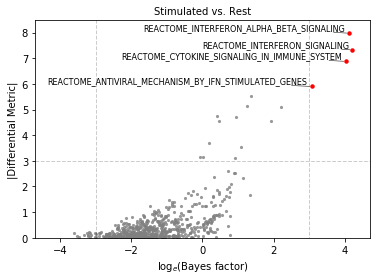

In [13]:
vega.plotting.volcano(model.adata, group1='stimulated', group2='rest', title='Stimulated vs. Rest')

Additionally, we can visualize the weights attributed to each gene in a given pathway to understand the main drivers of variability in the dataset.

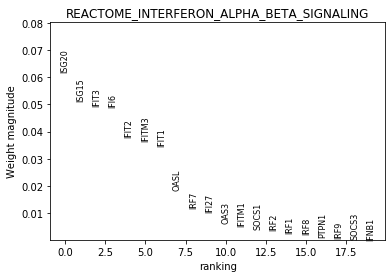

In [14]:
vega.plotting.rank_gene_weights(model, gmv_list=['REACTOME_INTERFERON_ALPHA_BETA_SIGNALING'], n_genes=20, color_in_set=False)

## Exporting results

We can use pandas to export the differential activity results to look at it later. 

In [15]:
#da_df.to_csv('./da_results.tsv', sep='\t')